In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import scipy
import scipy.stats

In [2]:
figure_path = './figures'
os.makedirs(figure_path, exist_ok=True)

In [3]:
colors = {
    #https://onlinelibrary.wiley.com/doi/full/10.1002/rth2.12308
    'dark_blue': '#003366',
    'special_red': '#E31B23',
    'medium_blue': '#005CAB',
    'special_yellow': '#FFC325',
    'cb_green': '#1b9e77',
    'cb_orange': '#d95f02',
    'cb_purple': '#7570b3'
}


parameters = {
    'A': {
        'incidence': 0.25,
        'beta_counts': 10,
        'color': colors['medium_blue']
    },
    'B': {
        'incidence': 0.15,
        'beta_counts': 20,
        'color': colors['special_red']
    }
}

In [4]:
score_values = np.linspace(
    0.0001,
    0.9999,
    1000
)

In [5]:
# Compute beta parameters
for key, value in parameters.items():
    parameters[key]['alpha'] = value['incidence'] * value['beta_counts']
    parameters[key]['beta'] = (1-value['incidence']) * value['beta_counts']
    
    # Compute the unconditional distribution
    parameters[key]['x'] = score_values
    parameters[key]['pdf'] = scipy.stats.beta.pdf(parameters[key]['x'], parameters[key]['alpha'], parameters[key]['beta'])
    
    # Compute the conditional distributions
    parameters[key]['pdf_1'] = parameters[key]['x']*parameters[key]['pdf'] / parameters[key]['incidence']
    parameters[key]['pdf_0'] = (1-parameters[key]['x'])*parameters[key]['pdf'] / (1-parameters[key]['incidence'])
    parameters[key]['calibration_curve'] = (parameters[key]['pdf_1']*parameters[key]['incidence']) / parameters[key]['pdf']
    
    

In [6]:
# New group A-new, as a transformation of A to the conditional distributions of B
key = 'A-new'
source_group = 'A'
target_group = 'B'

parameters[key] = {'incidence': parameters[source_group]['incidence'], 'color': 'orange'}

parameters[key]['x'] = score_values

# Compute the conditional distributions
parameters[key]['pdf_1'] = parameters[target_group]['pdf_1']
parameters[key]['pdf_0'] = parameters[target_group]['pdf_0']
parameters[key]['pdf'] = (parameters[key]['pdf_1']*parameters[key]['incidence']) + (parameters[key]['pdf_0']*(1-parameters[key]['incidence']))
parameters[key]['calibration_curve'] = (parameters[key]['pdf_1']*parameters[key]['incidence']) / parameters[key]['pdf']

# New group B-new, as a transformation of B to the conditional distributions of A
key = 'B-new'
source_group = 'B'
target_group = 'A'

parameters[key] = {'incidence': parameters[source_group]['incidence'], 'color': 'g'}

parameters[key]['x'] = score_values

# Compute the conditional distributions
parameters[key]['pdf_1'] = parameters[target_group]['pdf_1']
parameters[key]['pdf_0'] = parameters[target_group]['pdf_0']
parameters[key]['pdf'] = (parameters[key]['pdf_1']*parameters[key]['incidence']) + (parameters[key]['pdf_0']*(1-parameters[key]['incidence']))
parameters[key]['calibration_curve'] = (parameters[key]['pdf_1']*parameters[key]['incidence']) / parameters[key]['pdf']


In [7]:
def get_performance_metrics_group(parameter_group):
    result = {}
    result['classification_rate'] = 1-scipy.integrate.cumulative_trapezoid(
        y=parameter_group['pdf'], 
        x=parameter_group['x'],
        initial=0
    )
    result['FNR'] = scipy.integrate.cumulative_trapezoid(
        y=parameter_group['pdf_1'], 
        x=parameter_group['x'],
        initial=0
    )
    result['TPR'] = 1-result['FNR']
    result['TNR'] = scipy.integrate.cumulative_trapezoid(
        y=parameter_group['pdf_0'], 
        x=parameter_group['x'],
        initial=0
    )
    result['FPR'] = 1-result['TNR']
    return result
    
    
    return result
  
performance_metrics_dict = {key: get_performance_metrics_group(value) for key, value in parameters.items()}
for key in parameters.keys():
    parameters[key].update(performance_metrics_dict[key])

In [8]:
def plot_distributions(
    parameters,
    plot_x='x', 
    plot_y='pdf', 
    ax=plt.gca(), 
    groups = None, 
    title='', 
    legend=False, 
    apply_fill=True,
    fill_min=None, 
    fill_max=None,
    threshold = None,
    calibration_curve=False,
    color_override=None
):
    
    if groups is None:
        groups = parameters.keys()
        
    if color_override is not None:
        color = color_override
    
    for key in groups:
        
        if color_override is None:
            color=parameters[key]['color']
        
        ax.plot(parameters[key][plot_x], parameters[key][plot_y], color=color)
        
        if apply_fill:
            if fill_min is None:
                fill_min = parameters[key][plot_x].min()
            if fill_max is None:
                fill_max = parameters[key][plot_x].max()

            fill_mask = (parameters[key][plot_x] >= fill_min) & (parameters[key][plot_x] <= fill_max)
            ax.fill_between(
                parameters[key][plot_x][fill_mask], 0, parameters[key][plot_y][fill_mask], color=color, alpha=0.5, label=f'Group {key}'
            )
            
        if threshold is not None:
            ax.axvline(threshold, color='k', linestyle='--')
            
        if calibration_curve:
            # Plot a dashed x=y for comparison with perfect calibration
            ax.plot(parameters[key][plot_x], parameters[key][plot_x], linestyle='--', color='gray', lw=2)

    ax.set_xlim([0, 1])
    ax.set_title(title, fontsize=18)

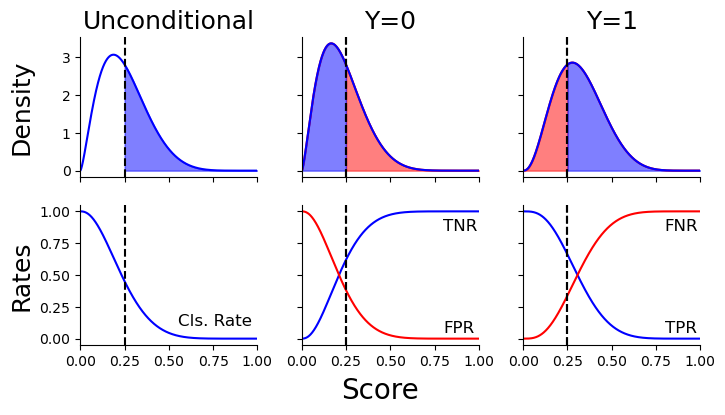

In [9]:
figsize=(8,4)
wspace=0.5
threshold=0.25
plt.close()
fig, axes = plt.subplots(2, 3, figsize=figsize, squeeze=False, sharey='row', sharex=True)
plt.subplots_adjust(wspace=0.25)

## Unconditional ##
plot_distributions(
    parameters, 
    plot_y='pdf', 
    ax=axes[0, 0], 
    title='Unconditional', 
    groups='A', 
    fill_min=threshold, 
    threshold=threshold,
    color_override='b'
)
axes[0, 0].set_ylabel('Density', fontsize=18)
plot_distributions(
    parameters, 
    plot_y='classification_rate', 
    ax=axes[1, 0],
    groups='A', 
    apply_fill=False,
    threshold=threshold,
    color_override='b'
)
axes[1, 0].set_ylabel('Rates', fontsize=18)
axes[1, 0].text(0.55, 0.1, 'Cls. Rate', fontsize=12)

## Y = 0
plot_distributions(
    parameters, 
    plot_y='pdf_0', 
    ax=axes[0, 1], 
#     title='Y=0', 
    groups='A', 
    fill_min=threshold, 
    threshold=threshold,
    color_override='r'
)
plot_distributions(
    parameters, 
    plot_y='pdf_0', 
    ax=axes[0, 1], 
    title='Y=0', 
    groups='A', 
    fill_min=0, 
    fill_max=threshold,
    threshold=threshold,
    color_override='b'
)
plot_distributions(
    parameters, 
    plot_y='TNR', 
    ax=axes[1, 1],
    groups='A', 
    apply_fill=False,
    threshold=threshold,
    color_override='b'
)
plot_distributions(
    parameters, 
    plot_y='FPR', 
    ax=axes[1, 1],
    groups='A', 
    apply_fill=False,
    threshold=threshold,
    color_override='r'
)
axes[1,1].text(0.8, 0.85, 'TNR', fontsize=12)
axes[1,1].text(0.8, 0.05, 'FPR', fontsize=12)

## Y = 1
plot_distributions(
    parameters, 
    plot_y='pdf_1', 
    ax=axes[0, 2], 
#     title='Y=1', 
    groups='A', 
    fill_min=0, 
    fill_max=threshold,
    threshold=threshold,
    color_override='r'
)
plot_distributions(
    parameters, 
    plot_y='pdf_1', 
    ax=axes[0, 2], 
    title='Y=1', 
    groups='A', 
    fill_min=threshold, 
#     fill_max=threshold,
    threshold=threshold,
    color_override='b'
)

plot_distributions(
    parameters, 
    plot_y='TPR', 
    ax=axes[1, 2],
    groups='A', 
    apply_fill=False,
    threshold=threshold,
    color_override='b'
)
plot_distributions(
    parameters, 
    plot_y='FNR', 
    ax=axes[1, 2],
    groups='A', 
    apply_fill=False,
    threshold=threshold,
    color_override='r'
)
axes[1,2].text(0.8, 0.85, 'FNR', fontsize=12)
axes[1,2].text(0.8, 0.05, 'TPR', fontsize=12)
fig.align_ylabels(axes[:, 0])
fig.text(0.5, -0.025, 'Score', ha='center', size=20)
sns.despine()
plt.show()
fig.savefig(os.path.join(figure_path, 'distribution_plots_tpr_fpr.png'), dpi=300, bbox_inches="tight")

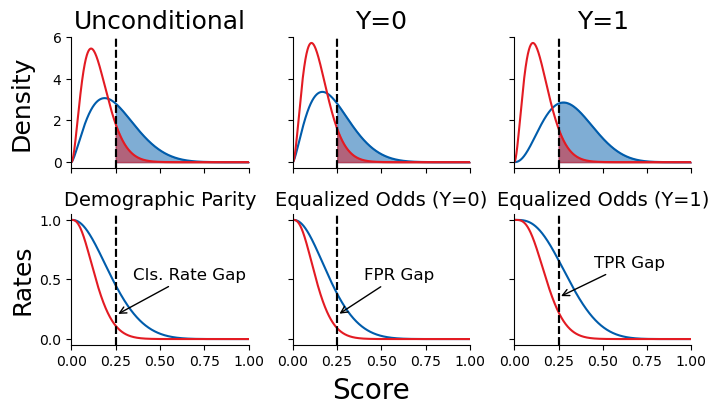

In [10]:
figsize=(8,4)
threshold=0.25
plt.close()
fig, axes = plt.subplots(2, 3, figsize=figsize, squeeze=False, sharey='row', sharex=True)
plt.subplots_adjust(wspace=0.25, hspace=0.35)

## Unconditional ##
plot_distributions(
    parameters, 
    plot_y='pdf', 
    ax=axes[0, 0], 
    title='Unconditional', 
    groups='A', 
    fill_min=threshold, 
    threshold=threshold
)
axes[0, 0].set_ylabel('Density', fontsize=18)
plot_distributions(
    parameters, 
    plot_y='classification_rate', 
    ax=axes[1, 0],
    groups='A', 
    apply_fill=False,
    threshold=threshold
)

plot_distributions(
    parameters, 
    plot_y='pdf', 
    ax=axes[0, 0], 
    title='Unconditional', 
    groups='B', 
    fill_min=threshold, 
    threshold=threshold
)
axes[0, 0].set_ylabel('Density', fontsize=18)
plot_distributions(
    parameters, 
    plot_y='classification_rate', 
    ax=axes[1, 0],
    groups='B', 
    apply_fill=False,
    threshold=threshold
)

axes[1, 0].set_ylabel('Rates', fontsize=18)
axes[1, 0].annotate('Cls. Rate Gap', xy=(0.25, 0.2), xytext=(0.35, 0.5), arrowprops={'arrowstyle': '->'}, fontsize=12)
axes[1, 0].set_title('Demographic Parity', fontsize=14)


## Y = 0
plot_distributions(
    parameters, 
    plot_y='pdf_0', 
    ax=axes[0, 1], 
    title='Y=0', 
    groups='A', 
    fill_min=threshold, 
    threshold=threshold,
)

plot_distributions(
    parameters, 
    plot_y='pdf_0', 
    ax=axes[0, 1], 
    title='Y=0', 
    groups='B', 
    fill_min=threshold, 
    threshold=threshold,
)

plot_distributions(
    parameters, 
    plot_y='FPR', 
    ax=axes[1, 1],
    groups='A', 
    fill_min=threshold,
    threshold=threshold,
    apply_fill=False
)

plot_distributions(
    parameters, 
    plot_y='FPR', 
    ax=axes[1, 1],
    groups='B', 
    fill_min=threshold,
    threshold=threshold,
    apply_fill=False
)
axes[1, 1].annotate('FPR Gap', xy=(0.25, 0.2), xytext=(0.4, 0.5), arrowprops={'arrowstyle': '->'}, fontsize=12)
axes[1, 1].set_title('Equalized Odds (Y=0)', fontsize=14)


## Y = 1
plot_distributions(
    parameters, 
    plot_y='pdf_1', 
    ax=axes[0, 2], 
    title='Y=1', 
    groups='A', 
    fill_min=threshold, 
    threshold=threshold,
)

plot_distributions(
    parameters, 
    plot_y='pdf_0', 
    ax=axes[0, 2], 
    title='Y=1', 
    groups='B', 
    fill_min=threshold, 
    threshold=threshold,
)

plot_distributions(
    parameters, 
    plot_y='TPR', 
    ax=axes[1, 2],
    groups='A', 
    fill_min=threshold,
    threshold=threshold,
    apply_fill=False
)

plot_distributions(
    parameters, 
    plot_y='TPR', 
    ax=axes[1, 2],
    groups='B', 
    fill_min=threshold,
    threshold=threshold,
    apply_fill=False
)
axes[1, 2].annotate('TPR Gap', xy=(0.25, 0.35), xytext=(0.45, 0.6), arrowprops={'arrowstyle': '->'}, fontsize=12)
axes[1, 2].set_title('Equalized Odds (Y=1)', fontsize=14)

## Plot figure
fig.align_ylabels(axes[:, 0])
fig.text(0.5, -0.025, 'Score', ha='center', size=20)
sns.despine()
plt.show()
fig.savefig(os.path.join(figure_path, 'two_groups_distribution_plots_demparity_eqodds.png'), dpi=300, bbox_inches="tight")

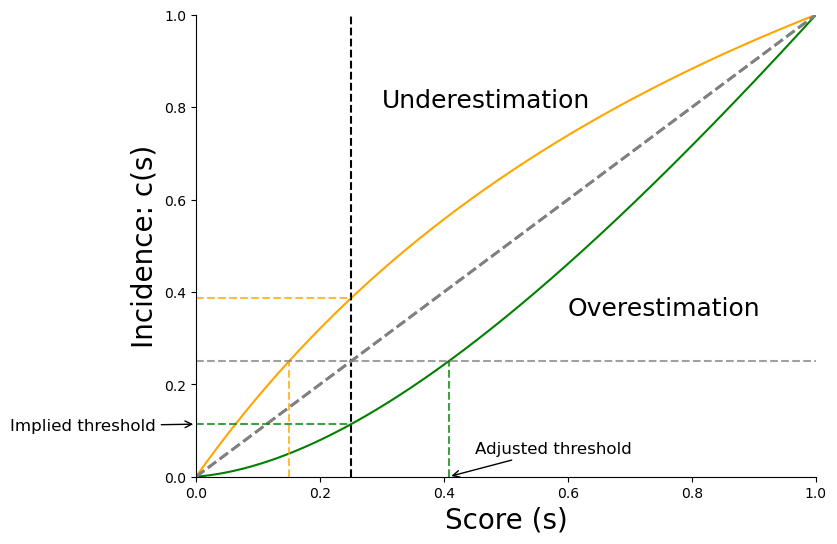

In [11]:
wspace=0.5
threshold=0.25
plt.close()

fig=plt.figure(figsize=(8,6))
ax=plt.gca()
ax.set_ylim(0, 1)
ax.set_xlim(0, 1)

plot_distributions(
    parameters,
    plot_y='calibration_curve',
    ax=ax,
    groups=['A-new'],
    color_override='orange',
    apply_fill=False,
    calibration_curve=True,
    threshold=threshold,
)
parameters['A-new']['calibration_curve_inverted'] = 2*parameters['A-new']['x'] - parameters['A-new']['calibration_curve']
plot_distributions(
    parameters,
    plot_y='calibration_curve_inverted',
    ax=ax,
    groups=['A-new'],
    color_override='g',
    apply_fill=False,
    calibration_curve=True
)

implicit_threshold_upper=parameters['A-new']['calibration_curve'][
    np.abs(parameters['A-new']['x'] - threshold).argmin()
]
implicit_threshold_lower=parameters['A-new']['calibration_curve_inverted'][
    np.abs(parameters['A-new']['x'] - threshold).argmin()
]
adjusted_threshold_upper=parameters['A-new']['x'][
    np.abs(parameters['A-new']['calibration_curve'] - threshold).argmin()
]
adjusted_threshold_lower=parameters['A-new']['x'][
    np.abs(parameters['A-new']['calibration_curve_inverted'] - threshold).argmin()
]
ax.axhline(
    implicit_threshold_upper, 
    xmax=threshold, 
    linestyle='--', 
    color='orange', 
    alpha=0.75
)
ax.axvline(
    adjusted_threshold_upper, 
    ymax=threshold, 
    linestyle='--', 
    color='orange', 
    alpha=0.75,
)
ax.axhline(
    implicit_threshold_lower, 
    xmax=threshold, 
    linestyle='--', 
    color='g', 
    alpha=0.75
)
ax.axvline(
    adjusted_threshold_lower, 
    ymax=threshold, 
    linestyle='--', 
    color='g', 
    alpha=0.75,
)
ax.axhline(
    threshold, 
    linestyle='--', 
    color='gray', 
    alpha=0.75
)
ax.set_xlabel('Score (s)', fontsize=20)
ax.set_ylabel('Incidence: c(s)', fontsize=20)
ax.text(0.6, 0.35, 'Overestimation', fontsize=18)
ax.text(0.3, 0.8, 'Underestimation', fontsize=18)
ax.annotate('Adjusted threshold', xy=(adjusted_threshold_lower, 0), xytext=(0.45, 0.05), arrowprops={'arrowstyle': '->'}, fontsize=12)
ax.annotate('Implied threshold', xy=(0, implicit_threshold_lower), xytext=(-0.3, 0.1), arrowprops={'arrowstyle': '->'}, fontsize=12)
sns.despine()
plt.show()
fig.savefig(os.path.join(figure_path, 'calibration_curve.png'), dpi=300, bbox_inches="tight")


In [14]:
# Utility functions
u_tp = 0.75
u_fn = 0
u_fp = 0
u_tn = 0.25

u_pos = u_tp - u_fn
u_neg = u_tn - u_fp
# optimal_threshold = u_neg / (u_pos+u_neg)

# risk_values = parameters['A']['x']

# u_treat = risk_values*u_tp + (1-risk_values)*u_fp
# u_no_treat = risk_values*u_fn + (1-risk_values)*u_tn
# conditional_utility = u_treat - u_no_treat

def get_conditional_utility(x):
    return (u_tp-u_fn)*x + (u_fp-u_tn)*(1-x)

for key in parameters.keys():
    parameters[key]['u_treat'] = parameters[key]['x'] * u_tp + (1-parameters[key]['x']) * u_fp
    parameters[key]['u_no_treat'] = parameters[key]['x'] * u_fn + (1-parameters[key]['x']) * u_tn
    parameters[key]['conditional_utility'] = get_conditional_utility(parameters[key]['calibration_curve'])
    parameters[key]['u_treat_integrated'] = scipy.integrate.cumulative_trapezoid(
        y=parameters[key]['u_treat']*parameters[key]['pdf'], 
        x=parameters[key]['x'],
        initial=0
    )
    parameters[key]['u_treat_integrated_complement'] = parameters[key]['u_treat_integrated'][-1] - parameters[key]['u_treat_integrated']
    parameters[key]['u_no_treat_integrated'] = scipy.integrate.cumulative_trapezoid(
        y=parameters[key]['u_no_treat']*parameters[key]['pdf'], 
        x=parameters[key]['x'],
        initial=0
    )
    parameters[key]['u_agg'] = parameters[key]['u_treat_integrated_complement'] + parameters[key]['u_no_treat_integrated']
    # Add NB, NB-fixed
    parameters[key]['nb'] = (
        parameters[key]['TPR']*parameters[key]['incidence'] - 
        parameters[key]['FPR']*(1-parameters[key]['incidence'])*parameters[key]['x']/(1-parameters[key]['x'])
    )
    parameters[key]['nb_fixed'] = (
        parameters[key]['TPR']*parameters[key]['incidence'] - 
        parameters[key]['FPR']*(1-parameters[key]['incidence'])*threshold/(1-threshold)
    )
    

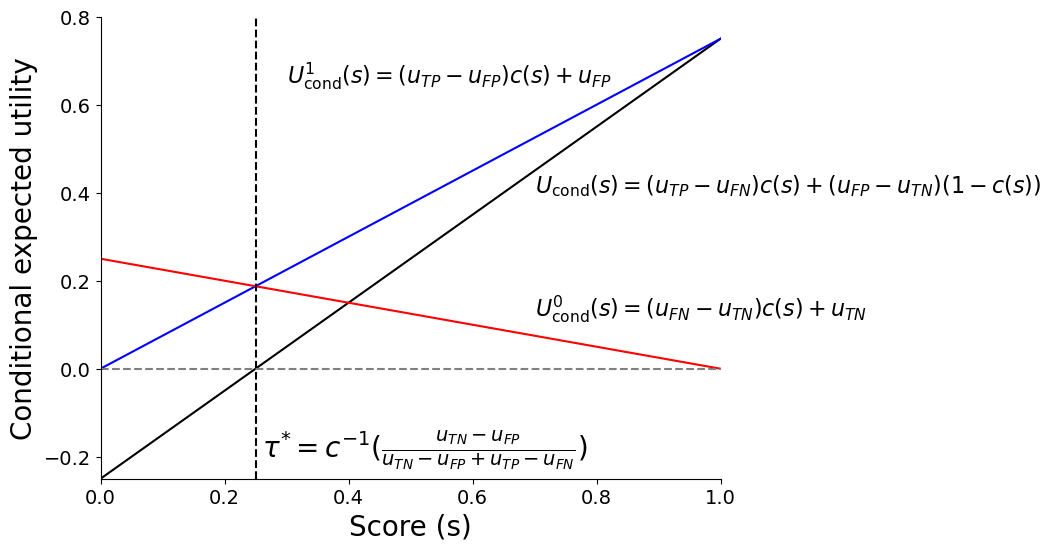

In [28]:
plt.close()
fig=plt.figure(figsize=(8,6))
ax=plt.gca()

# plt.plot(risk_values, conditional_utility, 'k')
# plt.plot(risk_values, u_treat, 'b')
# plt.plot(risk_values, u_no_treat, color='r')

plt.plot(parameters['A']['x'], parameters['A']['conditional_utility'], 'k')
plt.plot(parameters['A']['x'], parameters['A']['u_treat'], 'b')
plt.plot(parameters['A']['x'], parameters['A']['u_no_treat'], color='r')

plt.axvline(threshold, linestyle='--', color='k')
plt.axhline(0, linestyle='--', color='gray')


ax.set_xlabel('Score (s)', fontsize=20)
ax.set_ylabel('Conditional expected utility', fontsize=20)
ax.set_xlim(0, 1)
ax.set_ylim(-.25, 0.8)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.text(0.7, 0.12, r'$U_{\mathrm{cond}}^0(s)=(u_{FN}-u_{TN}) c(s) + u_{TN}$', fontsize=16)
ax.text(0.3, 0.65, r'$U_{\mathrm{cond}}^1(s)=(u_{TP}-u_{FP}) c(s) + u_{FP}$', fontsize=16)
ax.text(0.7, 0.4, r'$U_{\mathrm{cond}}(s)=(u_{TP}-u_{FN}) c(s) + (u_{FP}-u_{TN})(1-c(s))$', fontsize=16)
ax.text(0.26, -0.2, r'$\tau^{*}=c^{-1}(\frac{u_{TN}-u_{FP}}{u_{TN}-u_{FP} + u_{TP}-u_{FN}})$', fontsize=20)
sns.despine()
plt.show()
fig.savefig(os.path.join(figure_path, 'fixed_cost_utility_fn.png'), dpi=300, bbox_inches="tight")

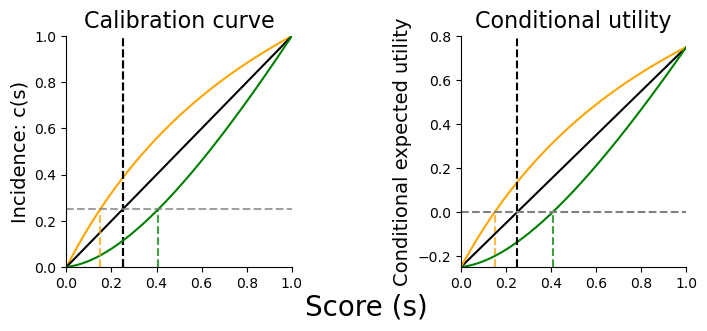

In [21]:
plt.close()
figsize=(8,3)
fig, axes = plt.subplots(1, 2, figsize=figsize, squeeze=False)
plt.subplots_adjust(wspace=0.75)

## Conditional utility
axes[0,1].set_xlim(0, 1)
axes[0,1].set_ylim(-.25, 0.8)
axes[0,1].plot(parameters['A']['x'], get_conditional_utility(parameters['A']['calibration_curve']), 'k')
axes[0,1].plot(parameters['A-new']['x'], get_conditional_utility(parameters['A-new']['calibration_curve']), color='orange')
axes[0,1].plot(parameters['A-new']['x'], get_conditional_utility(parameters['A-new']['calibration_curve_inverted']), color='g')
axes[0,1].axvline(threshold, linestyle='--', color='k')
axes[0,1].axhline(0, linestyle='--', color='gray')
axes[0,1].vlines(
    adjusted_threshold_upper, 
    ymin=-0.25,
    ymax=0, 
    linestyle='--', 
    color='orange', 
    alpha=0.75,
)
axes[0,1].vlines(
    adjusted_threshold_lower, 
    ymin=-0.25,
    ymax=0, 
    linestyle='--', 
    color='g', 
    alpha=0.75,
)

axes[0,1].set_ylabel('Conditional expected utility', fontsize=14)
axes[0,1].set_title('Conditional utility', fontsize=16)

## Calibration curves
axes[0,0].set_ylim(0, 1)
axes[0,0].set_xlim(0, 1)
plot_distributions(
    parameters,
    plot_y='calibration_curve',
    ax=axes[0,0],
    groups=['A-new'],
    color_override='orange',
    apply_fill=False,
    threshold=threshold,
)
plot_distributions(
    parameters,
    plot_y='calibration_curve',
    ax=axes[0,0],
    groups=['A'],
    color_override='k',
    apply_fill=False,
    threshold=threshold,
)

plot_distributions(
    parameters,
    plot_y='calibration_curve_inverted',
    ax=axes[0,0],
    groups=['A-new'],
    color_override='g',
    apply_fill=False,
)
axes[0,0].axhline(
    threshold, 
    linestyle='--', 
    color='gray', 
    alpha=0.75
)
axes[0,0].axvline(
    adjusted_threshold_upper, 
    ymax=threshold, 
    linestyle='--', 
    color='orange', 
    alpha=0.75,
)

axes[0,0].axvline(
    adjusted_threshold_lower, 
    ymax=threshold, 
    linestyle='--', 
    color='g', 
    alpha=0.75,
)
axes[0,0].set_ylabel('Incidence: c(s)', fontsize=14)
axes[0,0].set_title('Calibration curve', fontsize=16)

fig.text(0.5, -0.05, 'Score (s)', ha='center', size=20)
sns.despine()
plt.show()
fig.savefig(os.path.join(figure_path, 'calibration_utility.png'), dpi=300, bbox_inches="tight")

In [ ]:
# # Plot A and B

# plt.close()
# fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=figsize, sharey=False, sharex=True)
# axes = [ax1, ax2, ax3, ax4, ax5]
    
# plot_distributions(parameters, plot_y='pdf', ax=ax1, title='Unconditional', groups=['A','B'], fill_min=threshold, threshold=threshold)
# plot_distributions(parameters, plot_y='pdf_0', ax=ax2, title='Y=0', groups=['A','B'], fill_min=threshold, threshold=threshold)
# plot_distributions(parameters, plot_y='pdf_1', ax=ax3, title='Y=1', groups=['A','B'], fill_min=threshold, threshold=threshold)
# plot_distributions(parameters, plot_x='FPR', plot_y='TPR', ax=ax4, title='ROC', groups=['A','B'], apply_fill=False)

# plot_distributions(parameters, 
#     plot_y='calibration_curve', 
#     ax=ax5, 
#     title='Calibration', 
#     groups=['A','B'], 
#     apply_fill=False
# )

# fig.subplots_adjust(wspace=wspace)
# ax1.set_ylabel('Density', fontsize=12)
# ax4.set_ylabel('TPR', fontsize=12)
# ax4.set_xlabel('FPR', fontsize=12)
# ax5.set_ylabel('Incidence', fontsize=12)

# for ax in [ax1, ax2, ax3, ax5]:
#     ax.set_xlabel('Risk score', fontsize=12)

# ax1.sharey(ax2)
# ax3.sharey(ax2)

# sns.despine()
# plt.show()
# fig.savefig(os.path.join(figure_path, 'two_group_distributions.png'), dpi=300, bbox_inches="tight")

In [ ]:
# # Plot A-new and B

# plt.close()
# fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=figsize, sharey=False, sharex=True)
# axes = [ax1, ax2, ax3, ax4, ax5]
    
# plot_distributions(parameters, plot_y='pdf', ax=ax1, title='Unconditional', groups=['A-new','B'], fill_min=threshold, threshold=threshold)
# plot_distributions(parameters, plot_y='pdf_0', ax=ax2, title='Y=0', groups=['A-new','B'], fill_min=threshold, threshold=threshold)
# plot_distributions(parameters, plot_y='pdf_1', ax=ax3, title='Y=1', groups=['A-new','B'], fill_min=threshold, threshold=threshold)
# plot_distributions(parameters, plot_x='FPR', plot_y='TPR', ax=ax4, title='ROC', groups=['A-new','B'], apply_fill=False)

# plot_distributions(parameters, 
#     plot_y='calibration_curve', 
#     ax=ax5, 
#     title='Calibration', 
#     groups=['A-new','B'], 
#     apply_fill=False
# )

# fig.subplots_adjust(wspace=wspace)
# ax1.set_ylabel('Density', fontsize=12)
# ax4.set_ylabel('TPR', fontsize=12)
# ax4.set_xlabel('FPR', fontsize=12)
# ax5.set_ylabel('Incidence', fontsize=12)

# for ax in [ax1, ax2, ax3, ax5]:
#     ax.set_xlabel('Risk score', fontsize=12)

# ax1.sharey(ax2)
# ax3.sharey(ax2)

# sns.despine()
# plt.show()
# fig.savefig(os.path.join(figure_path, 'two_group_distributions_miscalibrated.png'), dpi=300, bbox_inches="tight")

### Utility
Assume a utility function, show that it entails an optimal threshold conditioned on the risk

In [ ]:
# # The values for the risk score
# risk_values = parameters['A']['x']

# # Conditional utility of treating vs not-treating
# u_treat = risk_values*u_tp + (1-risk_values)*u_fp
# u_no_treat = risk_values*u_fn + (1-risk_values)*u_tn
# conditional_utility = u_treat - u_no_treat

# # Miscalibrated model
# u_treat_miscalibrated = parameters['A-new']['calibration_curve']*u_tp + (1-parameters['A-new']['calibration_curve'])*u_fp
# u_no_treat_miscalibrated = parameters['A-new']['calibration_curve']*u_fn + (1-parameters['A-new']['calibration_curve'])*u_tn
# conditional_utility_miscalibrated = u_treat_miscalibrated - u_no_treat_miscalibrated
# optimal_threshold_miscalibrated = risk_values[np.abs(conditional_utility_miscalibrated).argmin()]
# print(f'Optimal miscalibrated threshold: {optimal_threshold_miscalibrated}')

In [ ]:
# # Cumulative utility
# cumulative_utility = np.zeros_like(risk_values)
# cumulative_utility_miscalibrated = np.zeros_like(risk_values)
# cumulative_utility_group_b = np.zeros_like(risk_values)

# for i, t in enumerate(risk_values):
#     threshold_mask = risk_values >= t
#     threshold_neg_mask = risk_values < t
#     # Calibrated model
#     try:
#         cumulative_utility_rhs = scipy.integrate.cumulative_trapezoid(
#             y=u_treat[threshold_mask]*parameters['A']['pdf'][threshold_mask],
#             x=risk_values[threshold_mask]
#         )[-1]
#     except:
#         cumulative_utility_rhs = 0.0
#     try:
#         cumulative_utility_lhs = scipy.integrate.cumulative_trapezoid(
#             y=u_no_treat[threshold_neg_mask]*parameters['A']['pdf'][threshold_neg_mask],
#             x=risk_values[threshold_neg_mask]
#         )[-1]
#     except:
#         cumulative_utility_lhs = 0.0
    
#     cumulative_utility[i] = cumulative_utility_rhs + cumulative_utility_lhs
    
#     # Miscalibrated model
#     try:
#         cumulative_utility_rhs_miscalibrated = scipy.integrate.cumulative_trapezoid(
#             y=u_treat_miscalibrated[threshold_mask]*parameters['A-new']['pdf'][threshold_mask],
#             x=risk_values[threshold_mask]
#         )[-1]
#     except:
#         cumulative_utility_rhs_miscalibrated = 0.0
#     try:
#         cumulative_utility_lhs_miscalibrated = scipy.integrate.cumulative_trapezoid(
#             y=u_no_treat_miscalibrated[threshold_neg_mask]*parameters['A-new']['pdf'][threshold_neg_mask],
#             x=risk_values[threshold_neg_mask]
#         )[-1]
#     except:
#         cumulative_utility_lhs_miscalibrated = 0.0
    
#     cumulative_utility_miscalibrated[i] = cumulative_utility_rhs_miscalibrated + cumulative_utility_lhs_miscalibrated
    
#     # Calibrated model
#     try:
#         cumulative_utility_rhs = scipy.integrate.cumulative_trapezoid(
#             y=u_treat[threshold_mask]*parameters['B']['pdf'][threshold_mask],
#             x=risk_values[threshold_mask]
#         )[-1]
#     except:
#         cumulative_utility_rhs = 0.0
#     try:
#         cumulative_utility_lhs = scipy.integrate.cumulative_trapezoid(
#             y=u_no_treat[threshold_neg_mask]*parameters['B']['pdf'][threshold_neg_mask],
#             x=risk_values[threshold_neg_mask]
#         )[-1]
#     except:
#         cumulative_utility_lhs = 0.0
    
#     cumulative_utility_group_b[i] = cumulative_utility_rhs + cumulative_utility_lhs

In [ ]:
# # Compute the implicit threshold
# implicit_threshold=parameters['A-new']['calibration_curve'][np.abs(parameters['A-new']['x'] - optimal_threshold).argmin()]
# print(f'Implicit threshold: {implicit_threshold}')

In [ ]:
# # Make plot
# plt.close()
# fig, (ax3, ax1, ax2) = plt.subplots(1, 3, figsize=(10,3), sharex=True)
# fig.subplots_adjust(wspace=wspace)

# # ax = plt.gca()
# ax1.plot(risk_values, conditional_utility, color='b', label='A-calibrated')
# ax1.axvline(optimal_threshold, linestyle='--', color='b', alpha=0.5)
# ax1.axhline(color = 'k', linestyle='--', alpha=0.5)
# ax1.plot(risk_values, conditional_utility_miscalibrated, color='orange', label='A-miscalibrated')
# # ax1.plot(risk_values, conditional_utility, color='g', label='B-green', alpha=0.5)
# ax1.axvline(optimal_threshold_miscalibrated, color='orange', linestyle='--', alpha=0.5)

# # sns.despine()
# ax1.set_xlabel('Risk score', fontsize=12)
# ax1.set_ylabel('Condtional expected utility',fontsize=12)
# ax1.set_title('Conditional utility', fontsize=14)

# ax2.plot(risk_values, cumulative_utility, color='b', label='A-calibrated')
# ax2.plot(risk_values, cumulative_utility_miscalibrated, color='orange', label='A-miscalibrated')
# ax2.axvline(optimal_threshold, linestyle='--', color='b', alpha=0.5)
# ax2.axvline(optimal_threshold_miscalibrated, linestyle='--', color='orange', alpha=0.5)
# ax2.plot(risk_values, cumulative_utility_group_b, color='green', label='B-green')
# ax2.set_ylabel('Average population utility', fontsize=12)
# ax2.set_xlabel('Threshold',fontsize=12)
# ax2.set_title('Average utility', fontsize=14)

# ax3.plot(parameters['A']['x'], parameters['A']['calibration_curve'], color = parameters['A']['color'], label='A-calibrated')
# # ax3.plot(parameters['B']['x'], parameters['B']['calibration_curve'], color = parameters['B']['color'], label='B-green', alpha=0.5)
# ax3.plot(parameters['A-new']['x'], parameters['A-new']['calibration_curve'], color = parameters['A-new']['color'], label='A-miscalibrated')
# ax3.axvline(optimal_threshold, linestyle='--', color='b', alpha=0.5)
# ax3.axvline(optimal_threshold_miscalibrated, linestyle='--', color=parameters['A-new']['color'], alpha=0.5)
# ax3.axhline(implicit_threshold, xmax=optimal_threshold, linestyle='--', color=parameters['A']['color'], alpha=0.5)
# ax3.set_xlabel('Risk score', fontsize=12)
# ax3.set_ylabel('Incidence', fontsize=12)
# ax3.set_title('Calibration', fontsize=14)

# plt.legend(bbox_to_anchor=(0.5, 1))
# sns.despine()
# plt.show()
# fig.savefig(os.path.join(figure_path, 'utility_threshold.png'), dpi=300, bbox_inches="tight")